## Constant from IV-characteristics : <font color = 'sky blue'> $n_e, T_e, T_-, I_{sat+}$ </font>
<font size="2">
    [1] <a href="https://sci-hub.st/https://aip.scitation.org/doi/10.1063/1.4802252"> [2013] Langmuir probe analysis of highly electronegative plasmas</a> <br>
    [2] <a href="https://sci-hub.st/https://doi.org/10.1063/1.4903328"> [2014] Langmuir probe analysis in electronegative plasmas</a> <br>
    [3] <a href="https://sci-hub.st/https://doi.org/10.1063/1.874162"> [2000] How big is a small Langmuir probe?</a> <br>
    [4] <a href="https://sci-hub.st/10.1088/0022-3727/43/10/105204"> [2010] The plasma sheath around large discs and ion collection by planar Langmuir probes</a> <br>

In [10]:
import numpy as np
from scipy.optimize import fsolve
import xml.etree.ElementTree as ET
from scipy.integrate import simpson
from const import *
import matplotlib.pyplot as plt
import ldfparser
from scipy.integrate import solve_ivp

In [11]:
#######################
## Physical Constant ##
#######################
e = 1.6e-19 # electron charge [C]
epsilon_0 = 8.854e-12 # permittivity of vacuum [F/m]
kB = 1.38e-23 #Bolzmann const [kg m2/s2/K]
mp = 146*1.67e-27 # mass of positive ion [kg] SF6
Tm = 0.1 # Negative ion temperature [eV]
hr = 0.6 # h-factor
rp = 0.1e-3 # probe radius [m]
lp = 5.5e-3 # probe length [m]

In [12]:
class Iterative_method():
    def __init__(self, ne, Te, V_sat, I_sat, V_p):
        self.ne = ne
        self.Te = Te
        self.V_sat = V_sat
        self.I_sat = I_sat
        self.gamma = self.Te/Tm
        self.V_p = V_p
        self.De = np.sqrt(epsilon_0*kB*Te/(e**2*ne)) #electron debye length
        #print("ne : {:.2e}, Te : {}, V_sat : {}, I_sat : {:.2e}".format(ne,Te,V_sat,I_sat))
        
    def alpha_convert(self,a_0):
        def eqn21(a_s):
            return a_0 - a_s*np.exp(-1/2*(1+a_s)/(1+self.gamma*a_s)*(1-self.gamma))
        ans_arr = np.round(fsolve(eqn21,np.logspace(-2,2,5)),4)
        ans_arr = np.unique(ans_arr)
        a_s = min(ans_arr)
        print("a_0: {:.4f}\t a_s: {}\t gamma: {:.4f}\t sol_number: {}".format(a_0, a_s, self.gamma, len(ans_arr)))
        return a_s
    
    def modified_Bohm(self,a_s):
        uB = np.sqrt(e*self.Te/mp)*np.sqrt((1+a_s)/(1+self.gamma*a_s))
        return uB
    
    def r_sh_calculation(self, J): 
            r_sh = np.sqrt(4/9*epsilon_0*np.sqrt(2*e/mp)*(self.V_sat - self.V_p)**1.5/J)
            #r_sh = rp
            return r_sh
            
    def iteration(self):
        #print("ne : {:.2e}, Te : {}, V_sat : {}, I_sat : {:.2e}".format(self.ne,self.Te,self.V_sat,self.I_sat))
        count = 0
        a_0 = 3
        r_sh_0 = rp
        pi = 3.141592653589793
        S_eff = 2*(pi)*r_sh_0*lp
        
        while True:
            MAX_COUNT = 100
            count += 1
            a_s = self.alpha_convert(a_0)
            uB = self.modified_Bohm(a_s) # uB_k
            np = self.I_sat/(hr*S_eff*e*uB) # np_k , S_k-1
            comp = a_0 # for loop condition
            a_0 = np/self.ne-1 # a_0_k
            J = hr*e*np*uB # J_k
            r_sh = self.r_sh_calculation(J) #r_sh_k
            S_eff = 2*pi*r_sh*lp
            
            #print(count, a_0)
            
            if abs(comp - a_0) < 0.001*a_0:
                return a_0
                break
            if count == MAX_COUNT:
                print('-----------No Convergence!---------------------')
                break
        print('--------------------------------------------------')

In [13]:
def cal_sat(IV_df):
    V = np.array(IV_df['V'])
    I = np.array(IV_df['I'])
    return -V[0], -I[0]

def cal_Vp(IV_df):
    V = np.array(IV_df['V'])
    I = np.array(IV_df['I'])
    dIdV = np.gradient(I, V)
    Vp = V[np.argmax(dIdV)]
    return Vp

def cal_eepf(IV_df):
    Vp = cal_Vp(IV_df)
    V = np.array(IV_df['V'])
    I = np.array(IV_df['I'])
    
    I_adj = I[V<=Vp]
    V_adj = V[V<=Vp]-Vp
    dI = np.gradient(I_adj, V_adj)
    ddI = np.gradient(dI, V_adj)
    eepf = 2*ddI/e/Ap*np.sqrt(2*Me*(Vp-V_adj)/e)/np.sqrt(Vp-V_adj)
    eedf = 2*ddI/e/Ap*np.sqrt(2*Me*(Vp-V_adj)/e)
    return np.flip(-V_adj), np.flip(eepf), np.flip(eedf)

def cal_ne(V, eepf, V_lim):
    mask = V < V_lim
    eepf = eepf[mask]
    V = V[mask]
    return simpson(eepf, V)

def cal_Te(V, eedf, ne, V_lim):
    mask = V < V_lim
    eedf = eedf[mask]
    V = V[mask]
    return 2/3*simpson(eedf/ne*V, V)

In [14]:
workDir = './211221(SF6)/SF6/B field scan_20V 0mm/'
parser = ldfparser.LDF(workDir)

no eedf datas
./211221(SF6)/SF6/B field scan_20V 0mm/100.ldf


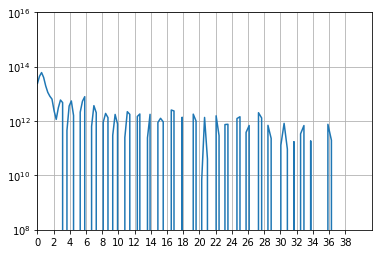

Enter limited energy
ne: 5.151e+13 [m-3]	 Te: 0.418 [eV]
a_0: 3.0000	 a_s: 1.7769	 gamma: 4.1767	 sol_number: 1
a_0: 5819.5213	 a_s: 3978.3129	 gamma: 4.1767	 sol_number: 1
a_0: 2313.8932	 a_s: 1581.6382	 gamma: 4.1767	 sol_number: 1
a_0: 1346.4835	 a_s: 920.2543	 gamma: 4.1767	 sol_number: 1
a_0: 1026.9599	 a_s: 701.8072	 gamma: 4.1767	 sol_number: 1
a_0: 896.8096	 a_s: 612.828	 gamma: 4.1767	 sol_number: 1
a_0: 838.0389	 a_s: 572.6485	 gamma: 4.1767	 sol_number: 1
a_0: 810.1089	 a_s: 553.5538	 gamma: 4.1767	 sol_number: 1
a_0: 796.4936	 a_s: 544.2455	 gamma: 4.1767	 sol_number: 1
a_0: 789.7717	 a_s: 539.65	 gamma: 4.1767	 sol_number: 1
a_0: 786.4320	 a_s: 537.3667	 gamma: 4.1767	 sol_number: 1
a_0: 784.7674	 a_s: 536.2287	 gamma: 4.1767	 sol_number: 1
a_0: 783.9364	 a_s: 535.6606	 gamma: 4.1767	 sol_number: 1
Vp: 4.52398, Vsat: 34.8616, Isat: 2.99043e-05


no eedf datas
./211221(SF6)/SF6/B field scan_20V 0mm/110.ldf


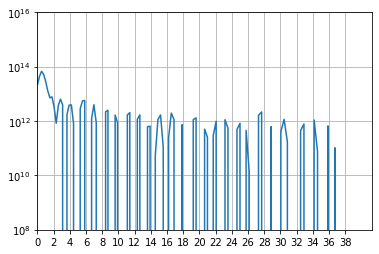

Enter limited energy
ne: 5.854e+13 [m-3]	 Te: 0.434 [eV]
a_0: 3.0000	 a_s: 1.7596	 gamma: 4.3385	 sol_number: 1
a_0: 4941.1227	 a_s: 3362.7218	 gamma: 4.3385	 sol_number: 1
a_0: 1935.0427	 a_s: 1316.7292	 gamma: 4.3385	 sol_number: 1
a_0: 1115.5292	 a_s: 758.9534	 gamma: 4.3385	 sol_number: 1
a_0: 846.7994	 a_s: 576.051	 gamma: 4.3385	 sol_number: 1
a_0: 737.7227	 a_s: 501.8114	 gamma: 4.3385	 sol_number: 1
a_0: 688.5530	 a_s: 468.3457	 gamma: 4.3385	 sol_number: 1
a_0: 665.2058	 a_s: 452.4552	 gamma: 4.3385	 sol_number: 1
a_0: 653.8294	 a_s: 444.7122	 gamma: 4.3385	 sol_number: 1
a_0: 648.2141	 a_s: 440.8903	 gamma: 4.3385	 sol_number: 1
a_0: 645.4244	 a_s: 438.9915	 gamma: 4.3385	 sol_number: 1
a_0: 644.0340	 a_s: 438.0453	 gamma: 4.3385	 sol_number: 1
a_0: 643.3400	 a_s: 437.5729	 gamma: 4.3385	 sol_number: 1
Vp: 4.47599, Vsat: 34.9108, Isat: 2.89551e-05


no eedf datas
./211221(SF6)/SF6/B field scan_20V 0mm/120.ldf


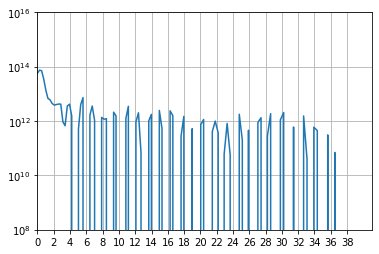

Enter limited energy
ne: 6.570e+13 [m-3]	 Te: 0.414 [eV]
a_0: 3.0000	 a_s: 1.7813	 gamma: 4.1371	 sol_number: 1
a_0: 4325.4468	 a_s: 2960.2529	 gamma: 4.1371	 sol_number: 1
a_0: 1657.6952	 a_s: 1134.3175	 gamma: 4.1371	 sol_number: 1
a_0: 947.3316	 a_s: 648.1111	 gamma: 4.1371	 sol_number: 1
a_0: 715.9569	 a_s: 489.7473	 gamma: 4.1371	 sol_number: 1
a_0: 622.3498	 a_s: 425.6782	 gamma: 4.1371	 sol_number: 1
a_0: 580.2216	 a_s: 396.8437	 gamma: 4.1371	 sol_number: 1
a_0: 560.2340	 a_s: 383.1632	 gamma: 4.1371	 sol_number: 1
a_0: 550.4984	 a_s: 376.4997	 gamma: 4.1371	 sol_number: 1
a_0: 545.6939	 a_s: 373.2113	 gamma: 4.1371	 sol_number: 1
a_0: 543.3073	 a_s: 371.5778	 gamma: 4.1371	 sol_number: 1
a_0: 542.1179	 a_s: 370.7637	 gamma: 4.1371	 sol_number: 1
a_0: 541.5242	 a_s: 370.3573	 gamma: 4.1371	 sol_number: 1
Vp: 4.22451, Vsat: 34.9131, Isat: 2.83229e-05


no eedf datas
./211221(SF6)/SF6/B field scan_20V 0mm/130.ldf


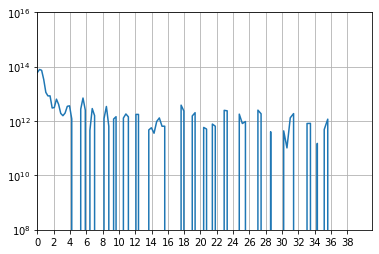

Enter limited energy
ne: 6.793e+13 [m-3]	 Te: 0.409 [eV]
a_0: 3.0000	 a_s: 1.7868	 gamma: 4.0888	 sol_number: 1
a_0: 4073.1364	 a_s: 2791.5474	 gamma: 4.0888	 sol_number: 1
a_0: 1541.5517	 a_s: 1056.334	 gamma: 4.0888	 sol_number: 1
a_0: 875.8909	 a_s: 600.0729	 gamma: 4.0888	 sol_number: 1
a_0: 660.0416	 a_s: 452.1243	 gamma: 4.0888	 sol_number: 1
a_0: 572.9051	 a_s: 392.3987	 gamma: 4.0888	 sol_number: 1
a_0: 533.7310	 a_s: 365.5477	 gamma: 4.0888	 sol_number: 1
a_0: 515.1547	 a_s: 352.815	 gamma: 4.0888	 sol_number: 1
a_0: 506.1090	 a_s: 346.6149	 gamma: 4.0888	 sol_number: 1
a_0: 501.6455	 a_s: 343.5555	 gamma: 4.0888	 sol_number: 1
a_0: 499.4285	 a_s: 342.0359	 gamma: 4.0888	 sol_number: 1
a_0: 498.3236	 a_s: 341.2786	 gamma: 4.0888	 sol_number: 1
a_0: 497.7721	 a_s: 340.9006	 gamma: 4.0888	 sol_number: 1
Vp: 4.27348, Vsat: 34.8612, Isat: 2.75467e-05


no eedf datas
./211221(SF6)/SF6/B field scan_20V 0mm/140.ldf


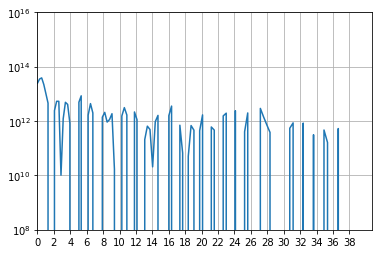

Enter limited energy
ne: 2.554e+13 [m-3]	 Te: 0.256 [eV]
a_0: 3.0000	 a_s: 2.0504	 gamma: 2.5587	 sol_number: 1
a_0: 10811.2775	 a_s: 7972.3683	 gamma: 2.5587	 sol_number: 1
a_0: 3810.1158	 a_s: 2809.5059	 gamma: 2.5587	 sol_number: 1
a_0: 2138.9835	 a_s: 1577.1638	 gamma: 2.5587	 sol_number: 1
a_0: 1602.4966	 a_s: 1181.5426	 gamma: 2.5587	 sol_number: 1
a_0: 1386.9927	 a_s: 1022.6237	 gamma: 2.5587	 sol_number: 1
a_0: 1290.3483	 a_s: 951.3553	 gamma: 2.5587	 sol_number: 1
a_0: 1244.5768	 a_s: 917.602	 gamma: 2.5587	 sol_number: 1
a_0: 1222.3023	 a_s: 901.1762	 gamma: 2.5587	 sol_number: 1
a_0: 1211.3147	 a_s: 893.0736	 gamma: 2.5587	 sol_number: 1
a_0: 1205.8579	 a_s: 889.0496	 gamma: 2.5587	 sol_number: 1
a_0: 1203.1387	 a_s: 887.0444	 gamma: 2.5587	 sol_number: 1
a_0: 1201.7814	 a_s: 886.0435	 gamma: 2.5587	 sol_number: 1
Vp: 4.12316, Vsat: 34.7301, Isat: 2.62316e-05


no eedf datas
./211221(SF6)/SF6/B field scan_20V 0mm/50.ldf


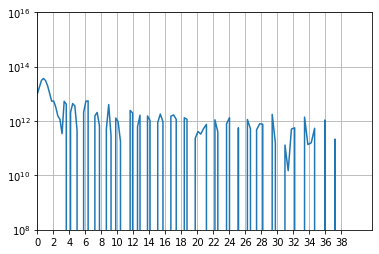

Enter limited energy
ne: 4.318e+13 [m-3]	 Te: 0.607 [eV]
a_0: 3.0000	 a_s: 1.6259	 gamma: 6.0740	 sol_number: 1
a_0: 6952.6558	 a_s: 4578.4715	 gamma: 6.0740	 sol_number: 1
a_0: 2944.5993	 a_s: 1938.88	 gamma: 6.0740	 sol_number: 1
a_0: 1740.9913	 a_s: 1146.2182	 gamma: 6.0740	 sol_number: 1
a_0: 1338.5053	 a_s: 881.1524	 gamma: 6.0740	 sol_number: 1
a_0: 1173.5688	 a_s: 772.5299	 gamma: 6.0740	 sol_number: 1
a_0: 1098.8674	 a_s: 723.3337	 gamma: 6.0740	 sol_number: 1
a_0: 1063.3140	 a_s: 699.9193	 gamma: 6.0740	 sol_number: 1
a_0: 1045.9697	 a_s: 688.4968	 gamma: 6.0740	 sol_number: 1
a_0: 1037.4035	 a_s: 682.8554	 gamma: 6.0740	 sol_number: 1
a_0: 1033.1467	 a_s: 680.052	 gamma: 6.0740	 sol_number: 1
a_0: 1031.0248	 a_s: 678.6546	 gamma: 6.0740	 sol_number: 1
a_0: 1029.9655	 a_s: 677.9569	 gamma: 6.0740	 sol_number: 1
Vp: 5.07517, Vsat: 34.8019, Isat: 3.09005e-05


no eedf datas
./211221(SF6)/SF6/B field scan_20V 0mm/60.ldf


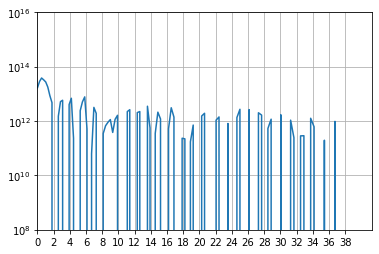

Enter limited energy
ne: 4.234e+13 [m-3]	 Te: 0.486 [eV]
a_0: 3.0000	 a_s: 1.7105	 gamma: 4.8628	 sol_number: 1
a_0: 7189.6756	 a_s: 4832.685	 gamma: 4.8628	 sol_number: 1
a_0: 2939.9133	 a_s: 1975.9354	 gamma: 4.8628	 sol_number: 1
a_0: 1723.4451	 a_s: 1158.2084	 gamma: 4.8628	 sol_number: 1
a_0: 1319.3746	 a_s: 886.5866	 gamma: 4.8628	 sol_number: 1
a_0: 1154.3306	 a_s: 775.6417	 gamma: 4.8628	 sol_number: 1
a_0: 1079.7017	 a_s: 725.4751	 gamma: 4.8628	 sol_number: 1
a_0: 1044.2114	 a_s: 701.618	 gamma: 4.8628	 sol_number: 1
a_0: 1026.9048	 a_s: 689.9843	 gamma: 4.8628	 sol_number: 1
a_0: 1018.3590	 a_s: 684.2397	 gamma: 4.8628	 sol_number: 1
a_0: 1014.1128	 a_s: 681.3853	 gamma: 4.8628	 sol_number: 1
a_0: 1011.9963	 a_s: 679.9626	 gamma: 4.8628	 sol_number: 1
a_0: 1010.9397	 a_s: 679.2523	 gamma: 4.8628	 sol_number: 1
Vp: 4.5259, Vsat: 34.8515, Isat: 3.07701e-05


no eedf datas
./211221(SF6)/SF6/B field scan_20V 0mm/70.ldf


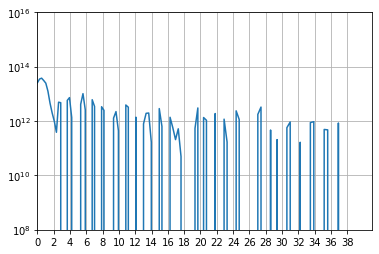

Enter limited energy
ne: 4.123e+13 [m-3]	 Te: 0.429 [eV]
a_0: 3.0000	 a_s: 1.765	 gamma: 4.2871	 sol_number: 1
a_0: 7260.1272	 a_s: 4947.9151	 gamma: 4.2871	 sol_number: 1
a_0: 2877.5243	 a_s: 1960.9103	 gamma: 4.2871	 sol_number: 1
a_0: 1669.9269	 a_s: 1137.8607	 gamma: 4.2871	 sol_number: 1
a_0: 1271.9621	 a_s: 866.624	 gamma: 4.2871	 sol_number: 1
a_0: 1110.0394	 a_s: 756.264	 gamma: 4.2871	 sol_number: 1
a_0: 1036.9616	 a_s: 706.4572	 gamma: 4.2871	 sol_number: 1
a_0: 1002.2420	 a_s: 682.7937	 gamma: 4.2871	 sol_number: 1
a_0: 985.3193	 a_s: 671.2599	 gamma: 4.2871	 sol_number: 1
a_0: 976.9650	 a_s: 665.566	 gamma: 4.2871	 sol_number: 1
a_0: 972.8144	 a_s: 662.7371	 gamma: 4.2871	 sol_number: 1
a_0: 970.7457	 a_s: 661.3271	 gamma: 4.2871	 sol_number: 1
a_0: 969.7130	 a_s: 660.6233	 gamma: 4.2871	 sol_number: 1
Vp: 4.27374, Vsat: 34.8543, Isat: 2.9927e-05


no eedf datas
./211221(SF6)/SF6/B field scan_20V 0mm/80.ldf


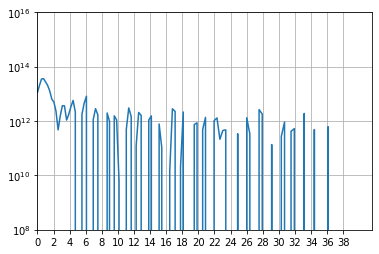

Enter limited energy
ne: 4.148e+13 [m-3]	 Te: 0.533 [eV]
a_0: 3.0000	 a_s: 1.6736	 gamma: 5.3338	 sol_number: 1
a_0: 7208.2057	 a_s: 4801.3275	 gamma: 5.3338	 sol_number: 1
a_0: 2980.8073	 a_s: 1985.2981	 gamma: 5.3338	 sol_number: 1
a_0: 1750.4962	 a_s: 1165.7415	 gamma: 5.3338	 sol_number: 1
a_0: 1341.2631	 a_s: 893.1358	 gamma: 5.3338	 sol_number: 1
a_0: 1173.9975	 a_s: 781.7139	 gamma: 5.3338	 sol_number: 1
a_0: 1098.3388	 a_s: 731.3148	 gamma: 5.3338	 sol_number: 1
a_0: 1062.3528	 a_s: 707.3432	 gamma: 5.3338	 sol_number: 1
a_0: 1044.8030	 a_s: 695.6526	 gamma: 5.3338	 sol_number: 1
a_0: 1036.1368	 a_s: 689.8797	 gamma: 5.3338	 sol_number: 1
a_0: 1031.8306	 a_s: 687.0112	 gamma: 5.3338	 sol_number: 1
a_0: 1029.6842	 a_s: 685.5814	 gamma: 5.3338	 sol_number: 1
a_0: 1028.6126	 a_s: 684.8676	 gamma: 5.3338	 sol_number: 1
Vp: 4.82569, Vsat: 34.807, Isat: 3.04609e-05


no eedf datas
./211221(SF6)/SF6/B field scan_20V 0mm/90.ldf


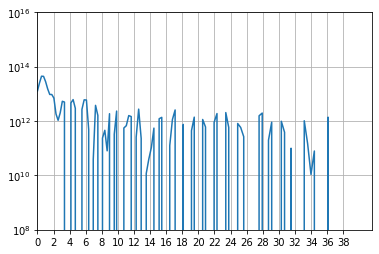

Enter limited energy
ne: 4.556e+13 [m-3]	 Te: 0.496 [eV]
a_0: 3.0000	 a_s: 1.7023	 gamma: 4.9606	 sol_number: 1
a_0: 6578.3023	 a_s: 4412.7545	 gamma: 4.9606	 sol_number: 1
a_0: 2698.8207	 a_s: 1810.193	 gamma: 4.9606	 sol_number: 1
a_0: 1583.3556	 a_s: 1061.88	 gamma: 4.9606	 sol_number: 1
a_0: 1212.5910	 a_s: 813.1515	 gamma: 4.9606	 sol_number: 1
a_0: 1061.1015	 a_s: 711.5243	 gamma: 4.9606	 sol_number: 1
a_0: 992.5904	 a_s: 665.5635	 gamma: 4.9606	 sol_number: 1
a_0: 960.0069	 a_s: 643.7047	 gamma: 4.9606	 sol_number: 1
a_0: 944.1171	 a_s: 633.045	 gamma: 4.9606	 sol_number: 1
a_0: 936.2707	 a_s: 627.7812	 gamma: 4.9606	 sol_number: 1
a_0: 932.3719	 a_s: 625.1657	 gamma: 4.9606	 sol_number: 1
a_0: 930.4286	 a_s: 623.862	 gamma: 4.9606	 sol_number: 1
a_0: 929.4585	 a_s: 623.2112	 gamma: 4.9606	 sol_number: 1
Vp: 4.82437, Vsat: 34.8078, Isat: 3.035e-05




In [15]:
distances, nes, nms, alphas, Vps, Tes, Nis = [], [], [], [], [], [], []

ldf_files = parser.ldf_paths()
for file in ldf_files:
    IV, eedf, result = parser.pull_attr(file, need_return=True)
    print(file)
    distance = float(file.split('/')[-1][:-4])
    
    Vsat, Isat = cal_sat(IV)
    Vp = cal_Vp(IV)
    my_V, my_eepf, my_eedf = cal_eepf(IV)
    
    plt.plot(my_V, my_eepf)
    plt.yscale('log')
    plt.ylim(1e8, 1e16)
    plt.xlim(0,)
    plt.xticks(np.arange(0,40,2))
    plt.grid(True)
    plt.show()
    print("Enter limited energy")
    V_lim = input()
    V_lim = np.float32(V_lim)
    ne = cal_ne(my_V, my_eepf, V_lim)
    Te = cal_Te(my_V, my_eepf, ne, V_lim)
    print('ne: {:.3e} [m-3]\t Te: {:.3f} [eV]'.format(ne, Te))

    exp = Iterative_method(ne,Te,Vsat,Isat,Vp)
    alpha = exp.iteration()
    nm = ne*alpha
    print("Vp: {}, Vsat: {}, Isat: {}\n\n".format(Vp, Vsat, Isat))
    
    Vps.append(Vp)
    alphas.append(alpha)
    nes.append(ne)
    nms.append(nm)
    distances.append(distance)
    Tes.append(Te)

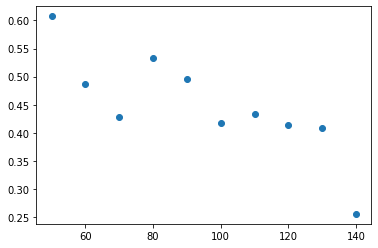

In [16]:
plt.scatter(distances, Tes)

Text(0, 0.5, '$\\alpha_0$')

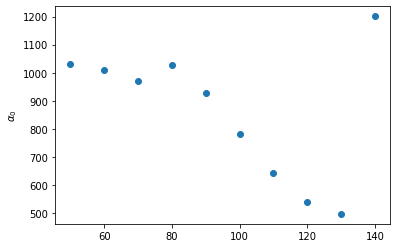

In [18]:
plt.scatter(distances, alphas)
plt.ylabel(r'$\alpha_0$')

In [20]:
distances

[100.0, 110.0, 120.0, 130.0, 140.0, 50.0, 60.0, 70.0, 80.0, 90.0]

Text(0, 0.5, 'Electron density $[m^{-3}]$')

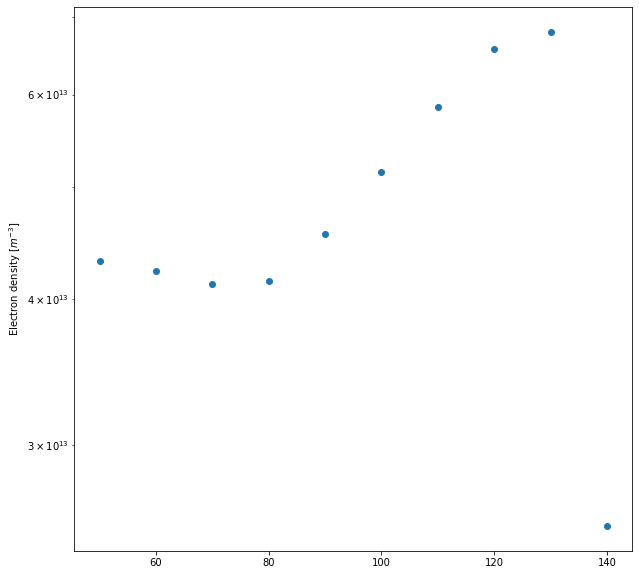

In [21]:
plt.figure(figsize=(10, 10))
plt.scatter(distances, nes)
plt.yscale('log')
plt.ylabel('Electron density $[m^{-3}]$')

(0.0, 15.0)

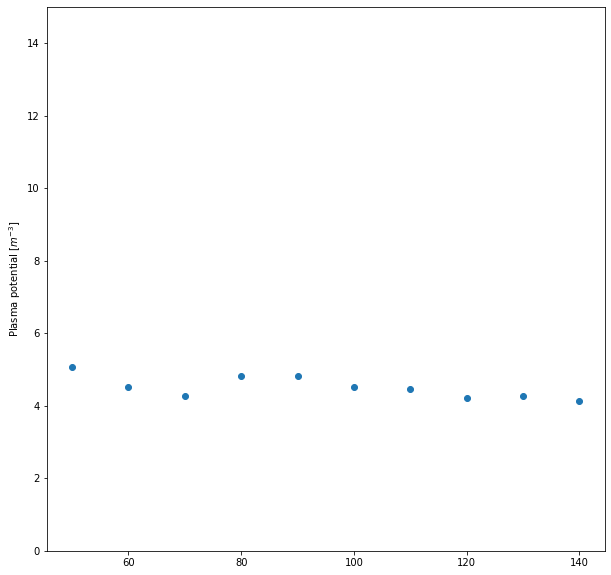

In [22]:
plt.figure(figsize=(10, 10))
plt.scatter(distances, Vps)
plt.ylabel('Plasma potential $[m^{-3}]$')
plt.ylim(0,15)

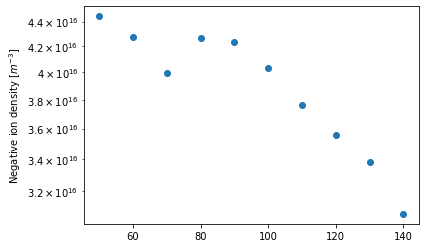

In [23]:
plt.ylabel('Negative ion density $[m^{-3}]$')
plt.scatter(distances, nms)
plt.yscale('log')

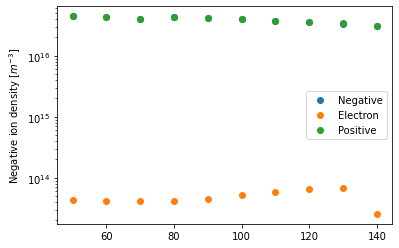

In [25]:
plt.scatter(distances, nms)
plt.scatter(distances, nes)
plt.scatter(distances, np.array(nes) + np.array(nms))
plt.yscale('log')
plt.ylabel('Negative ion density $[m^{-3}]$')
plt.legend(['Negative', 'Electron', 'Positive'])

In [26]:
ne = result['Ne'][0]
Te = result['eepf_Te'][0]
Isat = result['Isat'][0]
Vsat = result['Vsat'][0]
Vp = result['Vp'][0]

In [42]:
ne = 1e14 # 1/m3
Te = 2 # eV
Isat = 0.000033
Vsat = 20.5937
Vp = 10

In [43]:
exp = Iterative_method(ne,Te,Vsat,Isat,Vp)
exp.iteration()

1 9.993144036088852
2 284.3567981085936
3 1426.5949749931574
4 3084.0299408756578
5 4530.528698625436
6 5490.731241753286
7 6044.568961118748
8 6342.08111325082
9 6496.2804703189695
10 6574.779524419255
11 6614.383824091366
--------------------------------------------------


In [ ]:
from scipy.integrate import solve_bvp
rp= 25e-6
J = 10
V = 50
uB = 100
R= 50e-5
def fun(r, y, r_sh):
    return np.vstack((r_sh*J/(r*epsilon_0*y[1])-y[0]/r, e*y[0]/(mp*y[1])))

def bc(ya,yb,p):
    return np.array([yb[0],ya[1]-np.sqrt(2*e*V/mp),yb[1]-uB])
# a=시작
# b=끝
# 0=E
# 1=u
n = 20
r = np.linspace(rp, 3*R, n)
y = np.array([np.linspace(V, 0, n)/(R-rp), np.linspace(np.sqrt(2*e*V/mp), uB, n)])

sol = solve_bvp(fun, bc, r, y,p=(10*rp,))

if sol.status != 0:
    print("WARNING: sol.status is %d" % sol.status)
print(sol.message)

plt.subplot(2, 1, 1)
plt.plot(sol.x, sol.y[0], color='#801010', label='$y_0(x)$')
plt.grid(alpha=0.5)
plt.legend(framealpha=1, shadow=True)
plt.subplot(2, 1, 2)
plt.plot(sol.x, sol.y[1], '-', color='C0', label='$y_1(x)$')
plt.xlabel('$x$')
plt.grid(alpha=0.5)
plt.legend(framealpha=1, shadow=True)
plt.show()